In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [4]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='24h',
    price_calculation='close',
)

In [14]:
environment_columns = ['open', 'close']

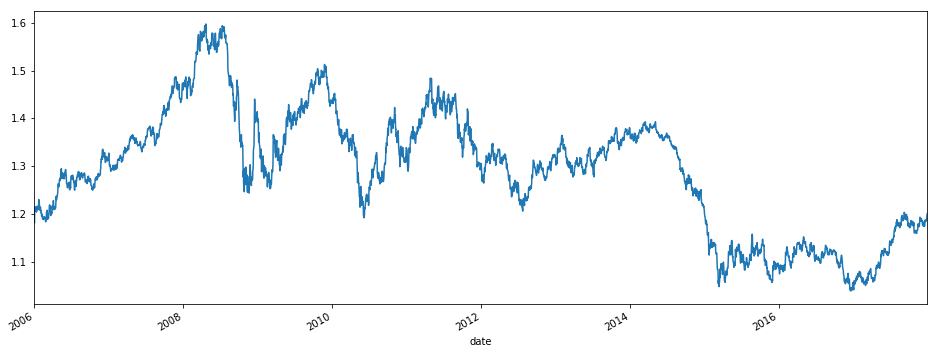

In [6]:
price_data['price'].plot(figsize=(16,6))

In [7]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 2549, test size 1274


In [8]:
episode=1000
batch_size=10

In [9]:
train_data.head(5)

,date,close,high,low,open,price
0,2006-01-01,1.1838,1.18460,1.18370,1.1844,1.1838
1,2006-01-02,1.1815,1.18665,1.18015,1.1839,1.1815
2,2006-01-03,1.2032,1.20350,1.18140,1.1814,1.2032
3,2006-01-04,1.2111,1.21438,1.20250,1.2033,1.2111
4,2006-01-05,1.2106,1.21220,1.20668,1.2110,1.2106


In [16]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [17]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 4373 pips, median trade count: 224
....................
episode: 40/1000
median profit: 5584 pips, median trade count: 230
....................
episode: 60/1000
median profit: 5141 pips, median trade count: 227
....................
episode: 80/1000
median profit: 5158 pips, median trade count: 227
....................
episode: 100/1000
median profit: 5701 pips, median trade count: 227
....................
episode: 120/1000
median profit: 5812 pips, median trade count: 225
....................
episode: 140/1000
median profit: 5785 pips, median trade count: 213
....................
episode: 160/1000
median profit: 6061 pips, median trade count: 220
....................
episode: 180/1000
median profit: 6020 pips, median trade count: 222
....................
episode: 200/1000
median profit: 6020 pips, median trade count: 220
....................
episode: 220/1000
median profit: 5812 pips, median trade count: 220
....................
ep

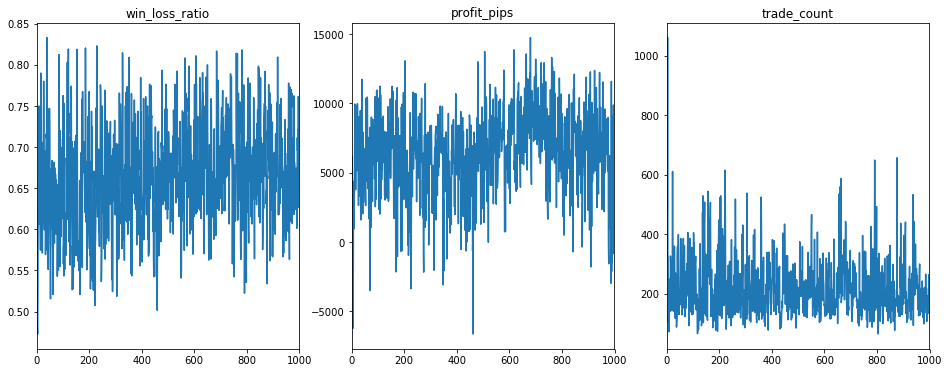

In [18]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [19]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['24h-EUR_USD-no-features.pkl']

## Test

In [20]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [21]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [22]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [23]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 1051.5499999999633 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139311810>]],
      dtype=object)

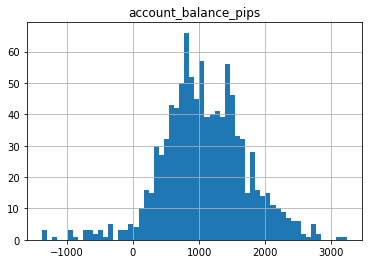

In [24]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [25]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [26]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [27]:
env._stats()

{'trade_count': 80,
 'win_loss_ratio': 0.6375,
 'account_balance': -0.015560000000004681,
 'unrealised_pl': 0.005535000000000068}

In [28]:
position_data = env.price_data.copy()

In [29]:
position_data['position'] = position_data['position'] - 1

In [30]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

82 positions to plot...


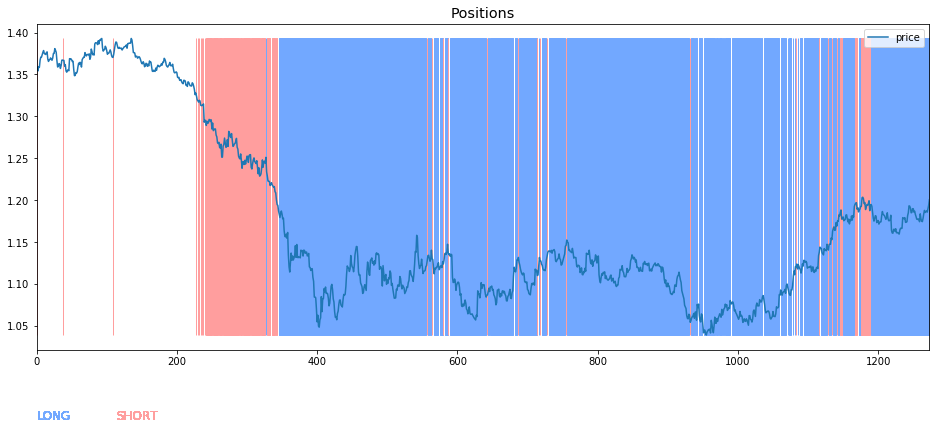

In [31]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [32]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 63.41%
Ratio of long to short positions: 1.08
Median profit: 0.0
Total profit: -0.003950000000000786
Median position length: 4.0
Number of trades: 82


In [33]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-11-29,1.35912,2013-12-01,1.35850,1,NaN,NaN,False,NaN
1,2014-01-13,1.36687,2014-01-14,1.36672,1,-1.0,0.00015,True,0.00015
2,2014-04-06,1.37038,2014-04-07,1.37419,1,-1.0,-0.00381,False,-0.00366
3,2014-08-22,1.32427,2014-08-24,1.31974,1,-1.0,0.00453,True,0.00087
4,2014-08-25,1.31862,2014-08-26,1.31696,1,-1.0,0.00166,True,0.00253
...,...,...,...,...,...,...,...,...,...
77,2017-08-07,1.17996,2017-08-27,1.19511,17,1.0,0.01515,True,-0.01848
78,2017-08-27,1.19511,2017-08-31,1.19101,4,-1.0,0.00410,True,-0.01438
79,2017-09-01,1.18598,2017-09-06,1.19264,4,1.0,0.00666,True,-0.00772
80,2017-09-06,1.19264,2017-09-21,1.19448,13,-1.0,-0.00184,False,-0.00956


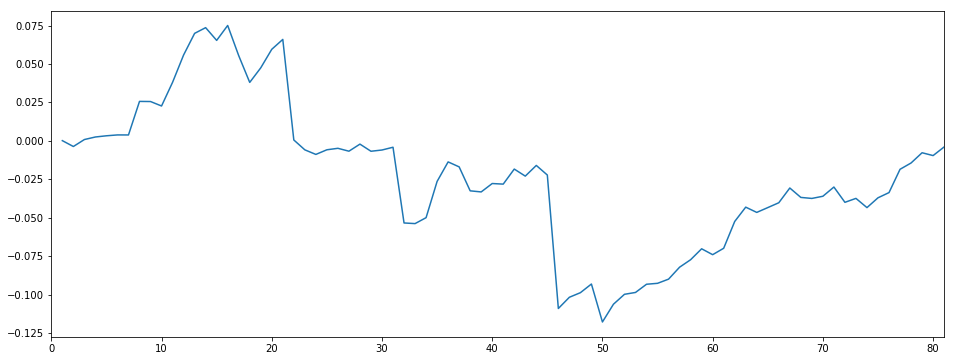

In [34]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.14232500000000003


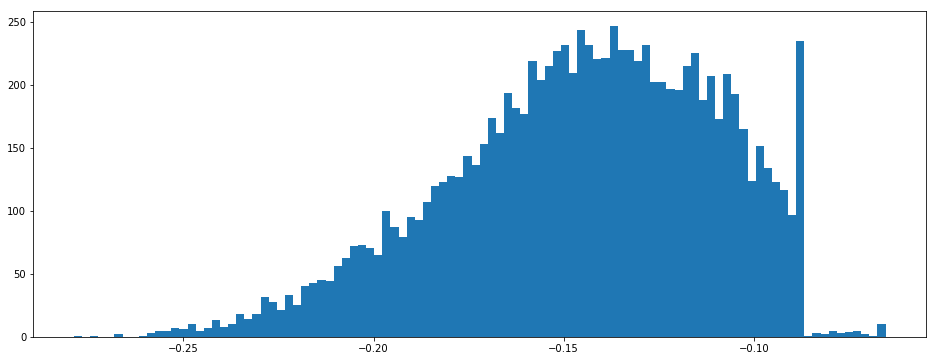

In [35]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);